# Parker Christenson Assignment 3

### Instructions
1. `Data Preparation`: Select a portion of the S&P 500 stock data for analysis. Perform preprocessing steps such as feature selection, normalization, and scaling to make the data suitable for the RNN model.

2. `Model Development`: Construct an RNN model using libraries like TensorFlow, or PyTorch. Incorporate LSTM units to address the vanishing gradient problem and improve memory retention across time steps.

3. `Training`: Train the RNN model on the prepared dataset, optimizing the loss function and choosing an appropriate optimizer to enhance model performance.

4. `Prediction`: Enable the model to forecast future stock prices, starting from a given initial stock price input.  

Ensure the RNN model efficiently learns from the selected stock price data and accurately forecasts future trends.


In [128]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
import visualkeras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
from tensorflow.keras.utils import model_to_dot
import matplotlib.pyplot as plt

In [70]:
df = pd.read_csv('M3-AAPL.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400


In [71]:
# making a new column % change from the previous close to the next days open
df['on%_change'] = (df['Open'].shift(-1) - df['Close']) / df['Close'] * 100

df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,on%_change
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853


In [72]:
# Now getting daily % change in the stock price (open to close)

df ['daily_change'] = (df['Close'] - df['Open']) / df['Open'] * 100
df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,on%_change,daily_change
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539,-0.385649
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339,0.544158
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969,0.196689
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736,-0.658224
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853,-1.309797


In [73]:
# if the close is greater than the open then the stock price increased and we will assign 1 to it, else 0 (green or red day)

df['green_red_day'] = np.where(df['Close'].shift(-1) > df['Open'], 1, 0)
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,on%_change,daily_change,green_red_day
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539,-0.385649,0
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339,0.544158,1
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969,0.196689,0
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736,-0.658224,0
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853,-1.309797,1


In [74]:
# getting the longest red and green streaks

def longest_streak(arr, value):
    max_streak = 0
    current_streak = 0
    
    for num in arr:
        if num == value:
            current_streak += 1
        else:
            if current_streak > max_streak:
                max_streak = current_streak
            current_streak = 0
    
    if current_streak > max_streak:
        max_streak = current_streak
    
    return max_streak

# calc
longest_red_streak = longest_streak(df['green_red_day'], 0)
longest_green_streak = longest_streak(df['green_red_day'], 1)

# print
print(f"longest streak of red days (0): {longest_red_streak}")
print(f"longest streak of green days (1): {longest_green_streak}")


longest streak of red days (0): 9
longest streak of green days (1): 17


In [75]:
# now getting the date ranges of the longest red and green streaks

def longest_streak_range(arr, value):
    max_streak = 0
    current_streak = 0
    start = 0
    end = 0
    current_start = 0
    
    for i, num in enumerate(arr):
        if num == value:
            current_streak += 1
            if current_streak == 1:
                current_start = i
        else:
            if current_streak > max_streak:
                max_streak = current_streak
                start = current_start
                end = i
            current_streak = 0
    
    if current_streak > max_streak:
        max_streak = current_streak
        start = current_start
        end = len(arr)
    
    return (start, end)

# calc
longest_red_streak_range = longest_streak_range(df['green_red_day'], 0)
longest_green_streak_range = longest_streak_range(df['green_red_day'], 1)

# print
print(f"longest streak of red days (0) range: {longest_red_streak_range}")
print(f"longest streak of green days (1) range: {longest_green_streak_range}")


longest streak of red days (0) range: (819, 828)
longest streak of green days (1) range: (1114, 1131)


# Model buildling using TensorFlow and netron

In [76]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,on%_change,daily_change,green_red_day
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539,-0.385649,0
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339,0.544158,1
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969,0.196689,0
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736,-0.658224,0
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853,-1.309797,1


#### Our target column is going to be the green_red_day column, because we are going to predict if the stock price will increase or decrease the next day, which will we we are going to take positions based off the predictions.

In [77]:
# Converting the green_red_day values to a green or red 0 for red and 1 for green

df['green_red_day'] = np.where(df['green_red_day'] == 0, 'red', 'green')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,on%_change,daily_change,green_red_day
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539,-0.385649,red
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339,0.544158,green
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969,0.196689,red
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736,-0.658224,red
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853,-1.309797,green


In [78]:
# Now we are going to scale the data using the StandardScaler

scaler = StandardScaler()

# scaling the data
scaled_data = scaler.fit_transform(df[['Open', 'High', 'Low', 'Close', 'Volume', 'on%_change', 'daily_change']])
scaled_data

# creating a new dataframe with the scaled data
df_scaled = pd.DataFrame(data=scaled_data, columns=['Open', 'High', 'Low', 'Close', 'Volume', 'on%_change', 'daily_change'])

# adding the green_red_day column to the new dataframe
df_scaled['green_red_day'] = df['green_red_day']

df_scaled.head()

,Open,High,Low,Close,Volume,on%_change,daily_change,green_red_day
0,-2.080578,-2.090787,-2.069417,-2.087329,0.293664,-0.824802,-0.327146,red
1,-2.095202,-2.097989,-2.080673,-2.092301,0.334755,0.237435,0.284106,green
2,-2.086252,-2.098686,-2.076724,-2.086920,-0.225165,-0.940356,0.055681,red
3,-2.096313,-2.105888,-2.086625,-2.105813,0.223925,0.222653,-0.506336,red
4,-2.099998,-2.106294,-2.114442,-2.116166,1.253326,0.963281,-0.934677,green


In [94]:
# Now we are going to make the architecture of the neural network with LTSM units and Dense layers

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(7, 8), return_sequences=True),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LSTM(128),
    tf.keras.layers.Dense(64),
    tf.keras.layers.Dense(32),
    tf.keras.layers.Dense(1, activation='sigmoid')
])



model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_18 (LSTM)              (None, 7, 128)            70144     
                                                                 
 lstm_19 (LSTM)              (None, 7, 128)            131584    
                                                                 
 lstm_20 (LSTM)              (None, 128)               131584    
                                                                 
 dense_18 (Dense)            (None, 64)                8256      
                                                                 
 dense_19 (Dense)            (None, 32)                2080      
                                                                 
 dense_20 (Dense)            (None, 1)                 33        
                                                                 
Total params: 343,681
Trainable params: 343,681
Non-tr

In [93]:
model.save('model.h5')

### `Here is the picture of the model `

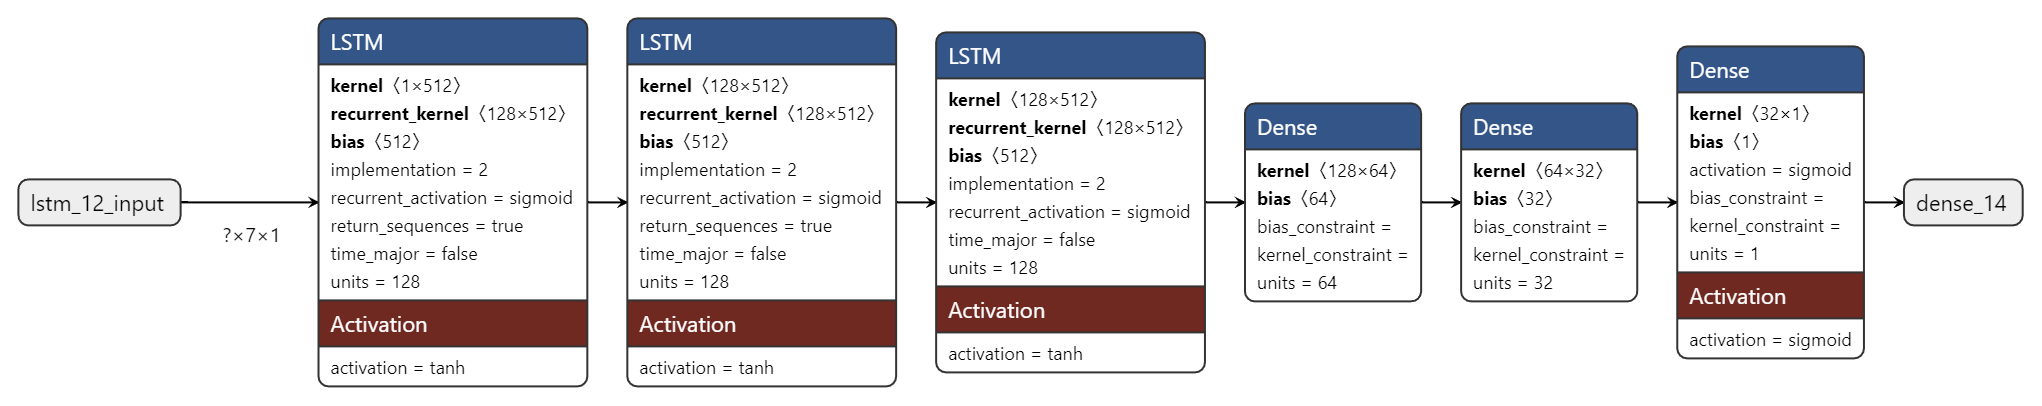


```diff
- So the shape of the input is wrong in the picture, it is actually 7 x 8 not 7 x 1
```




## Model training

In [95]:
# splitting the stock data into training and testing data
df_scaled.head()

,Open,High,Low,Close,Volume,on%_change,daily_change,green_red_day
0,-2.080578,-2.090787,-2.069417,-2.087329,0.293664,-0.824802,-0.327146,0
1,-2.095202,-2.097989,-2.080673,-2.092301,0.334755,0.237435,0.284106,1
2,-2.086252,-2.098686,-2.076724,-2.086920,-0.225165,-0.940356,0.055681,0
3,-2.096313,-2.105888,-2.086625,-2.105813,0.223925,0.222653,-0.506336,0
4,-2.099998,-2.106294,-2.114442,-2.116166,1.253326,0.963281,-0.934677,0


In [96]:
# target col
df_scaled['green_red_day'] = np.where(df_scaled['Close'] > df_scaled['Open'], 1, 0)

# x & y 
X = []
y = []

for i in range(7, df_scaled.shape[0]):
    X.append(df_scaled.iloc[i-7:i].values)
    y.append(df_scaled.iloc[i, -1])

X = np.array(X)
y = np.array(y)

# split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# check the shape 
print("Shape before reshaping:")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

print("Shape after reshaping (no reshaping needed):")
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")

# green and red days are balanced in the training and testing data
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Training data balance:", dict(zip(unique_train, counts_train)))
print("Testing data balance:", dict(zip(unique_test, counts_test)))

Shape before reshaping:
X_train: (1001, 7, 8), X_test: (251, 7, 8)
Shape after reshaping (no reshaping needed):
X_train: (1001, 7, 8), X_test: (251, 7, 8)
Training data balance: {0: 488, 1: 513}
Testing data balance: {0: 131, 1: 120}


In [97]:
# now we are going to compile the model

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [98]:
# train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
32/32 [==============================] - 7s 66ms/step - loss: 0.6946 - accuracy: 0.5035 - val_loss: 0.7026 - val_accuracy: 0.4781
Epoch 2/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6954 - accuracy: 0.5135 - val_loss: 0.6962 - val_accuracy: 0.4980
Epoch 3/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6925 - accuracy: 0.5225 - val_loss: 0.6989 - val_accuracy: 0.4900
Epoch 4/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6941 - accuracy: 0.5245 - val_loss: 0.6954 - val_accuracy: 0.4781
Epoch 5/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.5185 - val_loss: 0.6972 - val_accuracy: 0.4940
Epoch 6/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6915 - accuracy: 0.5375 - val_loss: 0.6961 - val_accuracy: 0.4582
Epoch 7/50
32/32 [==============================] - 0s 15ms/step - loss: 0.6929 - accuracy: 0.5045 - val_loss: 0.6965 - val_accuracy: 0.4741
Epoch 8/50
32

In [99]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 [==============================] - 0s 7ms/step - loss: 0.9310 - accuracy: 0.5060
Test Loss: 0.9309968948364258
Test Accuracy: 0.5059760808944702


In [100]:
# doing some predictions
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Training data balance:", dict(zip(unique_train, counts_train)))
print("Testing data balance:", dict(zip(unique_test, counts_test)))

Training data balance: {0: 488, 1: 513}
Testing data balance: {0: 131, 1: 120}


In [105]:
# Re normalizing and re-testing
from sklearn.preprocessing import MinMaxScaler # using MinMaxScaler to normalize the data instead of StandardScaler

if 'Date' in df.columns:
    dates = df['Date']
    df = df.drop(columns=['Date'])

df['green_red_day'] = np.where(df['Close'] > df['Open'], 1, 0)

target = df['green_red_day']
df = df.drop(columns=['green_red_day'])

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled['green_red_day'] = target.values


X = []
y = []

for i in range(7, df_scaled.shape[0]):
    X.append(df_scaled.iloc[i-7:i].values)
    y.append(df_scaled.iloc[i, df_scaled.columns.get_loc('green_red_day')])

X = np.array(X)
y = np.array(y)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# split checks
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Training data balance:", dict(zip(unique_train, counts_train)))
print("Testing data balance:", dict(zip(unique_test, counts_test)))

# build the model
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

Training data balance: {0: 454, 1: 547}
Testing data balance: {0: 122, 1: 129}


In [106]:

# setting the optimizer and compiling the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.0001),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

In [107]:
# Now training the mdoel

history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
32/32 [==============================] - 7s 51ms/step - loss: 0.6918 - accuracy: 0.5295 - val_loss: 0.6935 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 2/100
32/32 [==============================] - 0s 13ms/step - loss: 0.6891 - accuracy: 0.5465 - val_loss: 0.6937 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 3/100
32/32 [==============================] - 0s 13ms/step - loss: 0.6898 - accuracy: 0.5465 - val_loss: 0.6940 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 4/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6897 - accuracy: 0.5465 - val_loss: 0.6938 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 5/100
32/32 [==============================] - 0s 14ms/step - loss: 0.6888 - accuracy: 0.5465 - val_loss: 0.6947 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 6/100
32/32 [==============================] - 0s 13ms/step - loss: 0.6892 - accuracy: 0.5465 - val_loss: 0.6972 - val_accuracy: 0.5139 - lr: 0.0010
Epoch 7/100
32/32 [==============================] - 0s 13ms/step - lo

In [108]:
# eval
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

8/8 [==============================] - 0s 6ms/step - loss: 0.6935 - accuracy: 0.5139
Test Loss: 0.6934756636619568
Test Accuracy: 0.5139442086219788


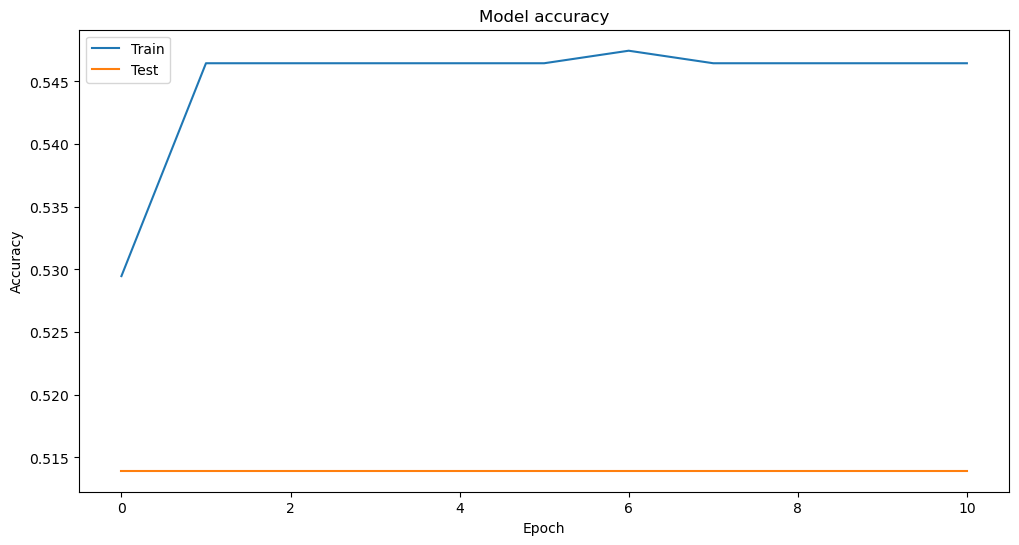

In [109]:
# training and eval scores

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

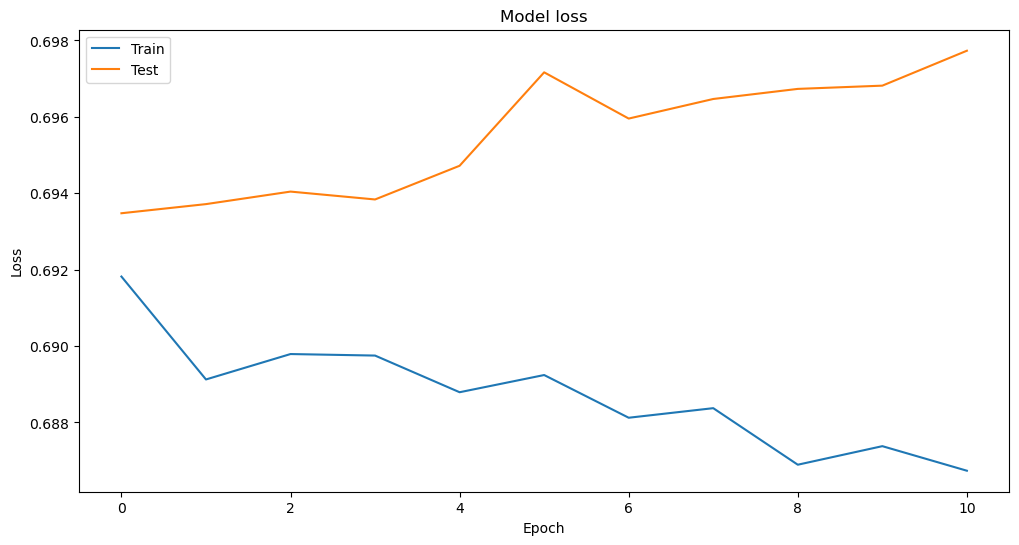

In [110]:
# train and val loss
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## So I had it stop with early stopping because the model did not continue to improve, but I am going to run it for 100 epochs to see if it improves increasing the patience to 50


In [114]:
# adjust
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True),  # Increased patience
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=100, min_lr=0.0001),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)
]

# re-run
history = model.fit(X_train, y_train, epochs=100, batch_size=100, validation_data=(X_test, y_test), callbacks=callbacks)

Epoch 1/100
11/11 [==============================] - 0s 28ms/step - loss: 0.6889 - accuracy: 0.5465 - val_loss: 0.6932 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 2/100
11/11 [==============================] - 0s 22ms/step - loss: 0.6890 - accuracy: 0.5465 - val_loss: 0.6931 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 3/100
11/11 [==============================] - 0s 22ms/step - loss: 0.6891 - accuracy: 0.5465 - val_loss: 0.6931 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 4/100
11/11 [==============================] - 0s 17ms/step - loss: 0.6893 - accuracy: 0.5465 - val_loss: 0.6931 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 5/100
11/11 [==============================] - 0s 17ms/step - loss: 0.6891 - accuracy: 0.5465 - val_loss: 0.6931 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 6/100
11/11 [==============================] - 0s 17ms/step - loss: 0.6890 - accuracy: 0.5465 - val_loss: 0.6932 - val_accuracy: 0.5139 - lr: 1.0000e-04
Epoch 7/100
11/11 [===========================

## I ran the model about 5 times, and the best accuracy was 54ish. So we are going to rebuild the model, and change some other things about it, and just try predicting the close price based off the previous 4 days as the input. 

In [115]:
# reload the data 

df = pd.read_csv('M3-AAPL.csv')

df['on%_change'] = (df['Open'].shift(-1) - df['Close']) / df['Close'] * 100

df.head()

df ['daily_change'] = (df['Close'] - df['Open']) / df['Open'] * 100
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,on%_change,daily_change
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539,-0.385649
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339,0.544158
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969,0.196689
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736,-0.658224
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853,-1.309797


In [122]:
# Re normalizing and re-testing using MinMaxScaler

if 'Date' in df.columns:
    dates = df['Date']
    df = df.drop(columns=['Date'])

df['green_red_day'] = np.where(df['Close'] > df['Open'], 1, 0)

target = df['green_red_day']
df = df.drop(columns=['green_red_day'])

scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

df_scaled['green_red_day'] = target.values

X = []
y = []

for i in range(7, df_scaled.shape[0]):
    X.append(df_scaled.iloc[i-7:i].values)
    y.append(df_scaled.iloc[i, df_scaled.columns.get_loc('green_red_day')])

X = np.array(X)
y = np.array(y)

# split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# split checks
unique_train, counts_train = np.unique(y_train, return_counts=True)
unique_test, counts_test = np.unique(y_test, return_counts=True)

print("Training data balance:", dict(zip(unique_train, counts_train)))
print("Testing data balance:", dict(zip(unique_test, counts_test)))


# building the model again

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1)  # No activation function this time because we are going to be trying to precdict the actual values within 20 cents of the actual value
])


# setting the optimizer and compiling the model
o=optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])  # switching to mean squared error

Training data balance: {0: 454, 1: 547}
Testing data balance: {0: 122, 1: 129}


In [123]:
# training not using callbacks 
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/100
32/32 [==============================] - 7s 76ms/step - loss: 0.3162 - mae: 0.5104 - val_loss: 0.2493 - val_mae: 0.4962
Epoch 2/100
32/32 [==============================] - 1s 28ms/step - loss: 0.2536 - mae: 0.4944 - val_loss: 0.2506 - val_mae: 0.4984
Epoch 3/100
32/32 [==============================] - 1s 25ms/step - loss: 0.2527 - mae: 0.4954 - val_loss: 0.2509 - val_mae: 0.5003
Epoch 4/100
32/32 [==============================] - 1s 26ms/step - loss: 0.2530 - mae: 0.4983 - val_loss: 0.2531 - val_mae: 0.4989
Epoch 5/100
32/32 [==============================] - 1s 27ms/step - loss: 0.2521 - mae: 0.4949 - val_loss: 0.2530 - val_mae: 0.4988
Epoch 6/100
32/32 [==============================] - 1s 26ms/step - loss: 0.2571 - mae: 0.4998 - val_loss: 0.2525 - val_mae: 0.5012
Epoch 7/100
32/32 [==============================] - 1s 27ms/step - loss: 0.2482 - mae: 0.4937 - val_loss: 0.2591 - val_mae: 0.4968
Epoch 8/100
32/32 [==============================] - 1s 25ms/step - loss: 0.

In [124]:
# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss (MSE): {loss}")
print(f"Test MAE: {mae}")

8/8 [==============================] - 0s 9ms/step - loss: 0.2633 - mae: 0.5029
Test Loss (MSE): 0.2632591426372528
Test MAE: 0.5029081702232361


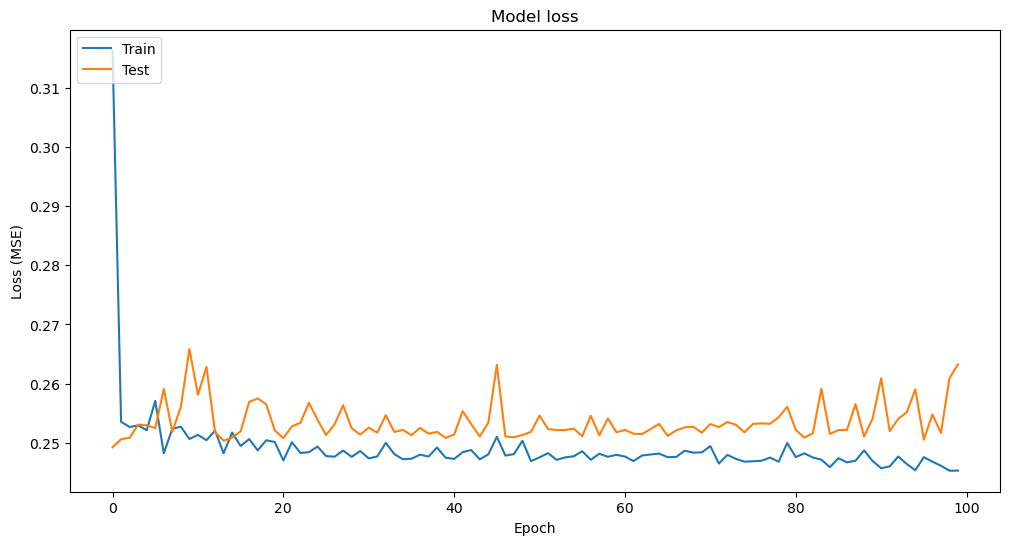

In [125]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss (MSE)')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

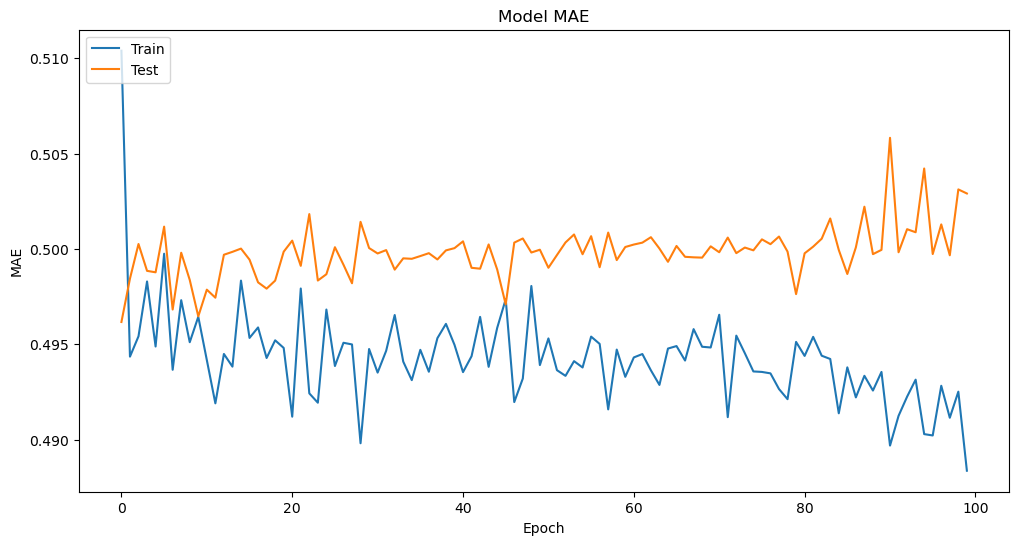

In [126]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['mae'])
plt.plot(history.history['val_mae'])
plt.title('Model MAE')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Attempting to build the model one more time


In [127]:
# reload the data

df = pd.read_csv('M3-AAPL.csv')

df['on%_change'] = (df['Open'].shift(-1) - df['Close']) / df['Close'] * 100

df.head()


,Date,Open,High,Low,Close,Adj Close,Volume,on%_change
0,2019-05-28,44.730000,45.147499,44.477501,44.557499,43.002316,111792800,-1.015539
1,2019-05-29,44.105000,44.837502,44.000000,44.345001,42.797237,113924800,0.321339
2,2019-05-30,44.487499,44.807499,44.167500,44.575001,43.019211,84873600,-1.160969
3,2019-05-31,44.057499,44.497501,43.747501,43.767502,42.239895,108174400,0.302736
4,2019-06-03,43.900002,44.480000,42.567501,43.325001,41.812828,161584400,1.234853


In [129]:
# col selection
data = df[['Open', 'High', 'Low', 'Close', 'Volume', 'on%_change']].values

# normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# sequences
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 7
sequences = create_sequences(scaled_data, seq_length)

# split
X = sequences[:, :-1, :]
y = sequences[:, -1, :]

# split to training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [130]:
def build_model(input_shape):
    model = Sequential()
    
    # conv layer
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.2))
    
    # LSTM
    model.add(LSTM(50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dropout(0.2))
    
    # connected layers
    model.add(Dense(25, activation='relu'))
    model.add(Dense(y_train.shape[1]))  # Output layer
    
    # complie 
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

input_shape = (seq_length - 1, X_train.shape[2])
model = build_model(input_shape)

# Model summary
model.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 5, 64)             832       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2, 64)            0         
 )                                                               
                                                                 
 dropout_12 (Dropout)        (None, 2, 64)             0         
                                                                 
 lstm_33 (LSTM)              (None, 2, 50)             23000     
                                                                 
 dropout_13 (Dropout)        (None, 2, 50)             0         
                                                                 
 lstm_34 (LSTM)              (None, 50)                20200     
                                                     

In [131]:
# train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/50
32/32 [==============================] - 6s 64ms/step - loss: 0.1792 - val_loss: 0.0329
Epoch 2/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0281 - val_loss: 0.0138
Epoch 3/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0169 - val_loss: 0.0045
Epoch 4/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0122 - val_loss: 0.0043
Epoch 5/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0113 - val_loss: 0.0034
Epoch 6/50
32/32 [==============================] - 1s 27ms/step - loss: 0.0100 - val_loss: 0.0036
Epoch 7/50
32/32 [==============================] - 1s 31ms/step - loss: 0.0092 - val_loss: 0.0034
Epoch 8/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0090 - val_loss: 0.0034
Epoch 9/50
32/32 [==============================] - 1s 24ms/step - loss: 0.0084 - val_loss: 0.0030
Epoch 10/50
32/32 [==============================] - 1s 26ms/step - loss: 0.0078 - val_loss: 0.0031
Epoch 11/

In [132]:
# predictions
predictions = model.predict(X_test)

# inverse 
predictions = scaler.inverse_transform(predictions)
y_test = scaler.inverse_transform(y_test)

# eval
mse = np.mean((predictions - y_test) ** 2)
print(f'Mean Squared Error: {mse}')

8/8 [==============================] - 1s 2ms/step
Mean Squared Error: 178388167035632.8


# Model eval with predictions

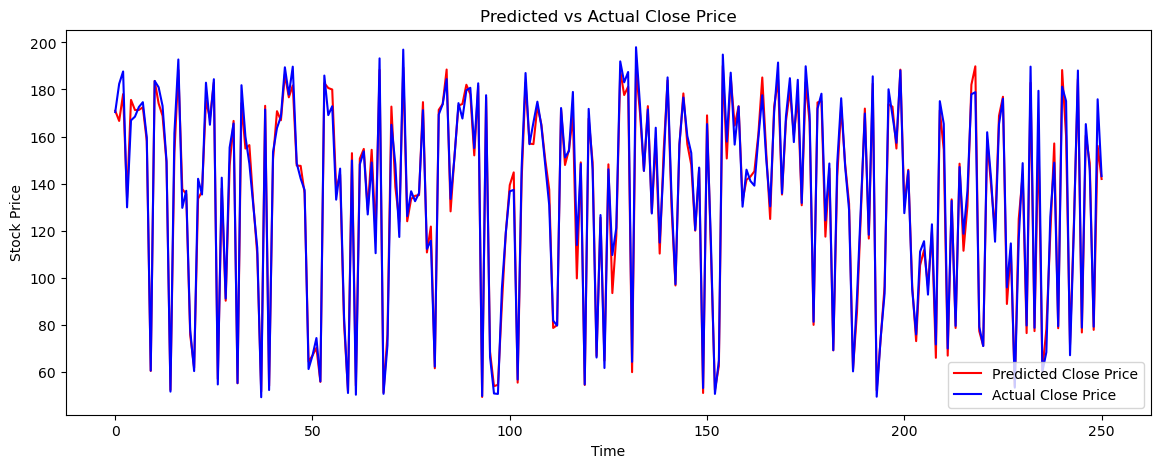

In [133]:
# Plot the predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(predictions[:, 3], color='red', label='Predicted Close Price')
plt.plot(y_test[:, 3], color='blue', label='Actual Close Price')
plt.title('Predicted vs Actual Close Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Conclusion

The model was not able to predict the stock price with very high accuracy, this last attempt was a little bit better, but training on stock prices is very difficult because it is very random, in the intra day fluctions of the price, and not having context behing the news that is driving the price up or down. For instance during covid the stock market sold off, but then the fed started buying up bonds, and the stock market went up. So it is very difficult to predict the stock market with just the stock prices.